# Task 5 – Account Security Monitoring (Anomaly Detection)

## Import libraries

In [86]:
# Data manipulation
import pandas as pd
import numpy as np
import math

# Regular Expression
import re

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

## Load dataset

In [48]:
task5_df = pd.read_csv('test.csv')
task5_df = task5_df.drop(columns=['id','player_id'])
task5_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25889 entries, 0 to 25888
Columns: 122 entries, login_count_1 to mass_item_sale
dtypes: float64(122)
memory usage: 24.1 MB


## EDA & Cleaning

### Column definition and grouping

In [49]:
scalar_columns = [
    'account_age_days',
    'behavior_stability',
    'password_changed',
    'vpn_usage',
    'suspicious_login_time',
    'mass_item_sale'
]

PATTERN = r'(.+)_\d$'
time_step_columns = [col for col in task5_df.columns 
                     if re.match(PATTERN, col) and col not in scalar_columns]

print("Length of time-step columns:", len(time_step_columns))
print("Length of scalar columns:", len(scalar_columns))

all_columns = time_step_columns + scalar_columns

Length of time-step columns: 116
Length of scalar columns: 6


In [50]:
groups = {}

for col in task5_df.columns:
    m = re.match(PATTERN, col)
    if m:
        base = m.group(1)
        groups.setdefault(base, []).append(col)

groups

{'login_count': ['login_count_1',
  'login_count_2',
  'login_count_3',
  'login_count_4'],
 'login_lat': ['login_lat_1', 'login_lat_2', 'login_lat_3', 'login_lat_4'],
 'login_lon': ['login_lon_1', 'login_lon_2', 'login_lon_3', 'login_lon_4'],
 'location_changes': ['location_changes_1',
  'location_changes_2',
  'location_changes_3',
  'location_changes_4'],
 'device_count': ['device_count_1',
  'device_count_2',
  'device_count_3',
  'device_count_4'],
 'ip_hash_entropy': ['ip_hash_entropy_1',
  'ip_hash_entropy_2',
  'ip_hash_entropy_3',
  'ip_hash_entropy_4'],
 'login_time_variance': ['login_time_variance_1',
  'login_time_variance_2',
  'login_time_variance_3',
  'login_time_variance_4'],
 'session_duration_mean': ['session_duration_mean_1',
  'session_duration_mean_2',
  'session_duration_mean_3',
  'session_duration_mean_4'],
 'session_duration_std': ['session_duration_std_1',
  'session_duration_std_2',
  'session_duration_std_3',
  'session_duration_std_4'],
 'skill_rating': ['

### Cleaning

In [51]:
# Find columns that contain negative values

negative_mask = task5_df < 0
cols_with_negatives = negative_mask.any()

cols_with_negatives[cols_with_negatives]

login_lat_1           True
login_lon_1           True
login_lat_2           True
login_lon_2           True
login_lat_3           True
login_lon_3           True
login_lat_4           True
login_lon_4           True
skill_trajectory_1    True
skill_trajectory_2    True
skill_trajectory_3    True
skill_trajectory_4    True
refund_count_2        True
refund_count_3        True
guild_changes_2       True
guild_changes_3       True
dtype: bool

In [ ]:
# Since guild_changes and refund_count values should be non-negative, we replace negative values with 0

non_negative_features = ['guild_changes', 'refund_count']

for base in non_negative_features:
    cols = [f"{base}_{i}" for i in range(1,5) if f"{base}_{i}" in task5_df.columns]
    task5_df[cols] = task5_df[cols].replace(-1, 0)

In [ ]:
# Perform linear interpolation for time_step_columns because they represent consecutive time periods

for base, cols in groups.items():
    cols = sorted(cols, key=lambda x: int(x.split("_")[-1]))
    task5_df[cols] = task5_df[cols].interpolate(method='linear', axis=1, limit_direction='both')

print("NaN of time_step_columns after interpolation:", task5_df[time_step_columns].isna().sum().sum())

# Fill remaining NaNs with the column median for features have missing values for all time steps
for col in time_step_columns:
    if task5_df[col].isna().sum() > 0:
        median_val = task5_df[col].median()
        task5_df[col] = task5_df[col].fillna(median_val)

print("NaN of time_step_columns after median impute:", task5_df[time_step_columns].isna().sum().sum())

print("NaN of all columns after impute:", task5_df.isna().sum().sum())

NaN of time_step_columns after interpolation: 16
NaN of time_step_columns after mean impute: 0
NaN of all columns after impute: 7491


In [ ]:
# for continuous features
task5_df['account_age_days'] = task5_df['account_age_days'].fillna(task5_df['account_age_days'].median())
task5_df['behavior_stability'] = task5_df['behavior_stability'].fillna(task5_df['behavior_stability'].median())

# for binary features
binary_features = ['password_changed', 'vpn_usage', 'suspicious_login_time', 'mass_item_sale']
task5_df[binary_features] = task5_df[binary_features].fillna(0)

print("NaN after all:", task5_df.isna().sum().sum())

NaN after all: 0


### Feature Engineering

In [66]:
new_features = []

for base, cols in groups.items():
    cols = sorted(cols, key=lambda x: int(x.split("_")[-1]))
    
    # Calculate features
    mean_col = task5_df[cols].mean(axis=1)
    std_col = task5_df[cols].std(axis=1)
    slope_col = (task5_df[cols[-1]] - task5_df[cols[0]]) / 3
    delta_col = task5_df[cols[-1]] - task5_df[cols[0]]
    last_col = task5_df[cols[-1]]
    
    # Create a temporary DataFrame for this group's new features
    group_features = pd.DataFrame({
        f"{base}_mean": mean_col,
        f"{base}_std": std_col,
        f"{base}_slope": slope_col,
        f"{base}_delta": delta_col,
        f"{base}_last": last_col
    })
    new_features.append(group_features)

# Concatenate all new features at once
if new_features:
    all_new_features = pd.concat(new_features, axis=1)
    temp_df = pd.concat([task5_df, all_new_features], axis=1)

# Drop original columns
X = temp_df.drop(columns=[c for cols in groups.values() for c in cols])

print("NaN in new features:", X.isna().sum().sum())
X.head()

NaN in new features: 0


,account_age_days,behavior_stability,password_changed,vpn_usage,suspicious_login_time,mass_item_sale,login_count_mean,login_count_std,login_count_slope,login_count_delta,...,communication_frequency_mean,communication_frequency_std,communication_frequency_slope,communication_frequency_delta,communication_frequency_last,guild_changes_mean,guild_changes_std,guild_changes_slope,guild_changes_delta,guild_changes_last
0,580.020715,0.830282,0.0,1.0,0.0,0.0,32.277530,6.515982,-1.057832,-3.173497,...,0.501127,0.076554,0.031633,0.094898,0.581692,1.50,0.577350,0.000000,0.0,1.0
1,1306.627890,0.700770,0.0,0.0,0.0,0.0,52.246713,6.074857,-4.049905,-12.149715,...,0.729943,0.085956,0.036234,0.108702,0.810700,0.25,0.500000,0.333333,1.0,1.0
2,835.638378,0.797991,0.0,0.0,0.0,0.0,30.467404,5.836629,2.579936,7.739807,...,0.866005,0.127647,-0.039251,-0.117752,0.708380,0.25,0.500000,0.000000,0.0,0.0
3,848.152938,0.736845,0.0,0.0,0.0,0.0,78.494843,5.031294,0.464854,1.394562,...,0.577085,0.095088,-0.010769,-0.032308,0.561340,2.00,0.816497,0.333333,1.0,3.0
4,379.053416,0.818901,0.0,0.0,0.0,0.0,61.330883,9.575072,5.759391,17.278172,...,0.516709,0.050304,0.013970,0.041909,0.521517,0.00,0.000000,0.000000,0.0,0.0


### EDA new features

In [100]:
X.describe()

,account_age_days,behavior_stability,password_changed,vpn_usage,suspicious_login_time,mass_item_sale,login_count_mean,login_count_std,login_count_slope,login_count_delta,...,communication_frequency_std,communication_frequency_slope,communication_frequency_delta,communication_frequency_last,guild_changes_mean,guild_changes_std,guild_changes_slope,guild_changes_delta,guild_changes_last,is_anomaly
count,25889.000000,25889.000000,25889.000000,25889.000000,25889.000000,25889.000000,25889.000000,25889.000000,25889.000000,25889.000000,...,25889.000000,25889.000000,25889.000000,25889.000000,25889.000000,25889.000000,25889.000000,25889.000000,25889.000000,25889.000000
mean,844.485698,0.818362,0.057631,0.153695,0.047820,0.026498,59.167776,7.292542,-0.009943,-0.029828,...,0.091176,0.000252,0.000757,0.742692,1.191153,0.545730,0.164162,0.492487,1.503843,0.100004
std,372.352843,0.088690,0.233048,0.360663,0.213388,0.160613,23.631514,4.093310,3.184922,9.554767,...,0.049038,0.039033,0.117100,0.275803,0.810216,0.271053,0.193888,0.581665,0.972383,0.300011
min,180.113522,0.201427,0.000000,0.000000,0.000000,0.000000,8.696331,0.000000,-12.163290,-36.489869,...,0.000000,-0.174354,-0.523063,0.000378,0.000000,0.000000,-0.666667,-2.000000,0.000000,0.000000
25%,529.845615,0.762616,0.000000,0.000000,0.000000,0.000000,38.850614,4.081287,-1.877311,-5.631933,...,0.053297,-0.023270,-0.069809,0.512253,0.500000,0.500000,0.000000,0.000000,1.000000,0.000000
50%,848.152938,0.822190,0.000000,0.000000,0.000000,0.000000,58.532129,6.543978,0.018295,0.054886,...,0.082844,0.000517,0.001550,0.740432,1.250000,0.500000,0.000000,0.000000,2.000000,0.000000
75%,1157.215422,0.882445,0.000000,0.000000,0.000000,0.000000,78.791877,9.922545,1.827205,5.481614,...,0.122756,0.024449,0.073348,0.963299,2.000000,0.577350,0.333333,1.000000,2.000000,0.000000
max,1499.967260,0.949999,1.000000,1.000000,1.000000,1.000000,120.628326,25.071222,14.474877,43.424630,...,0.305180,0.176196,0.528587,1.487784,3.000000,2.000000,1.333333,4.000000,4.000000,1.000000


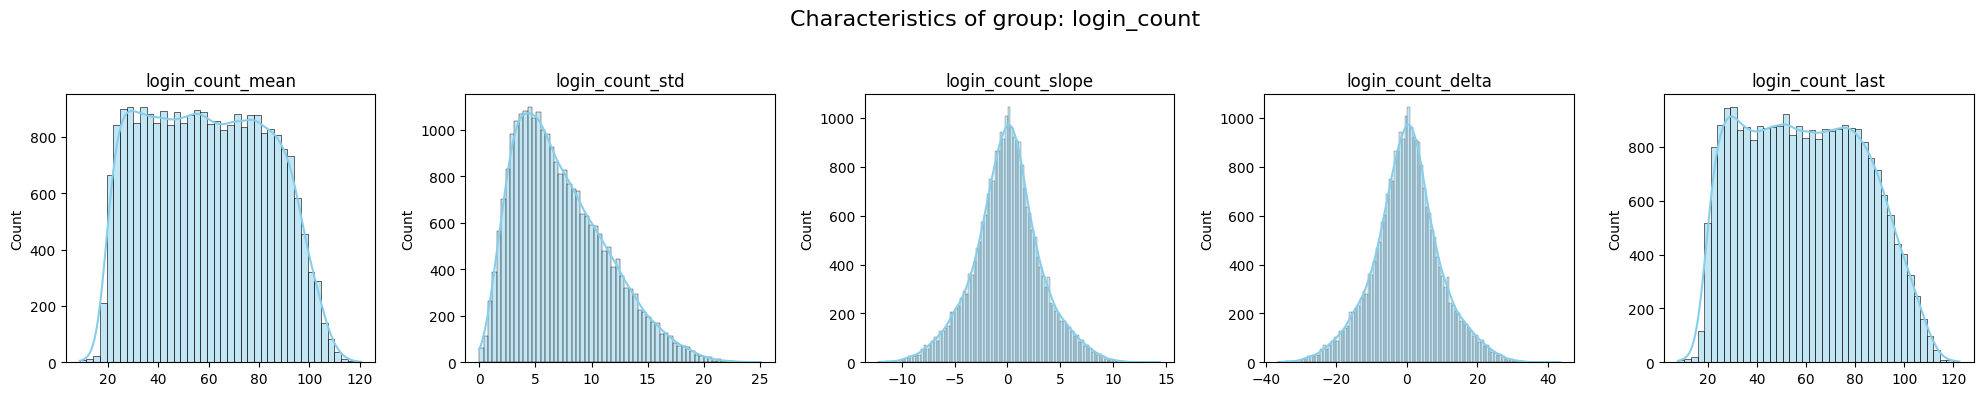

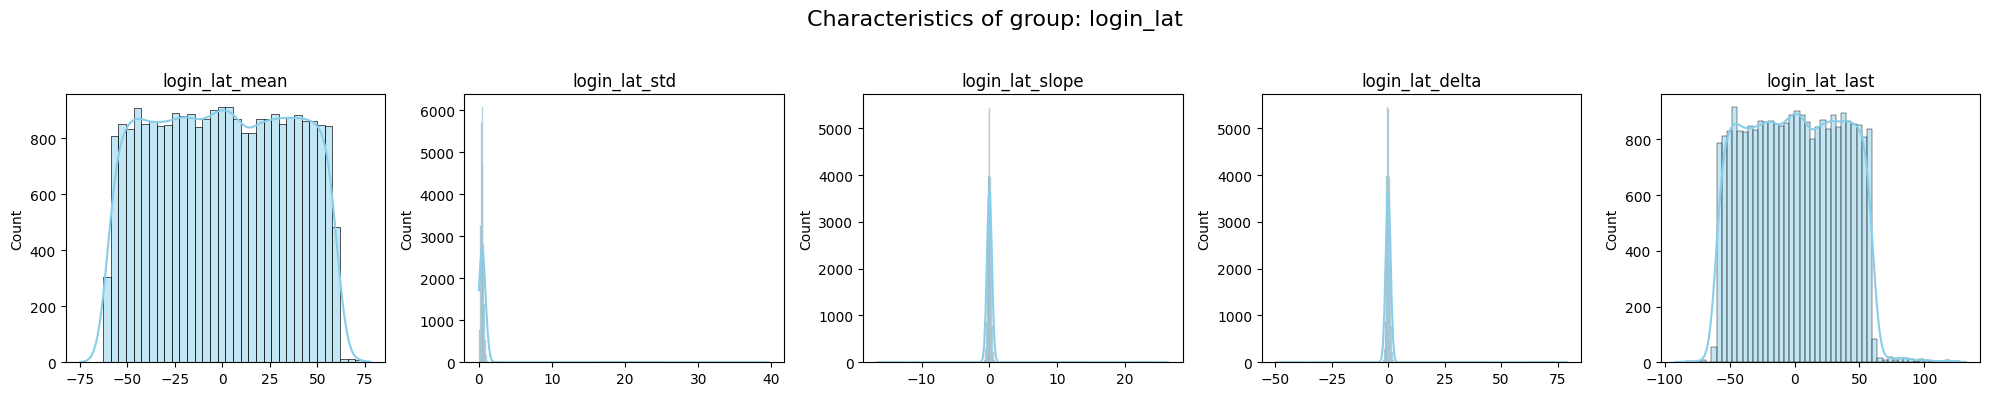

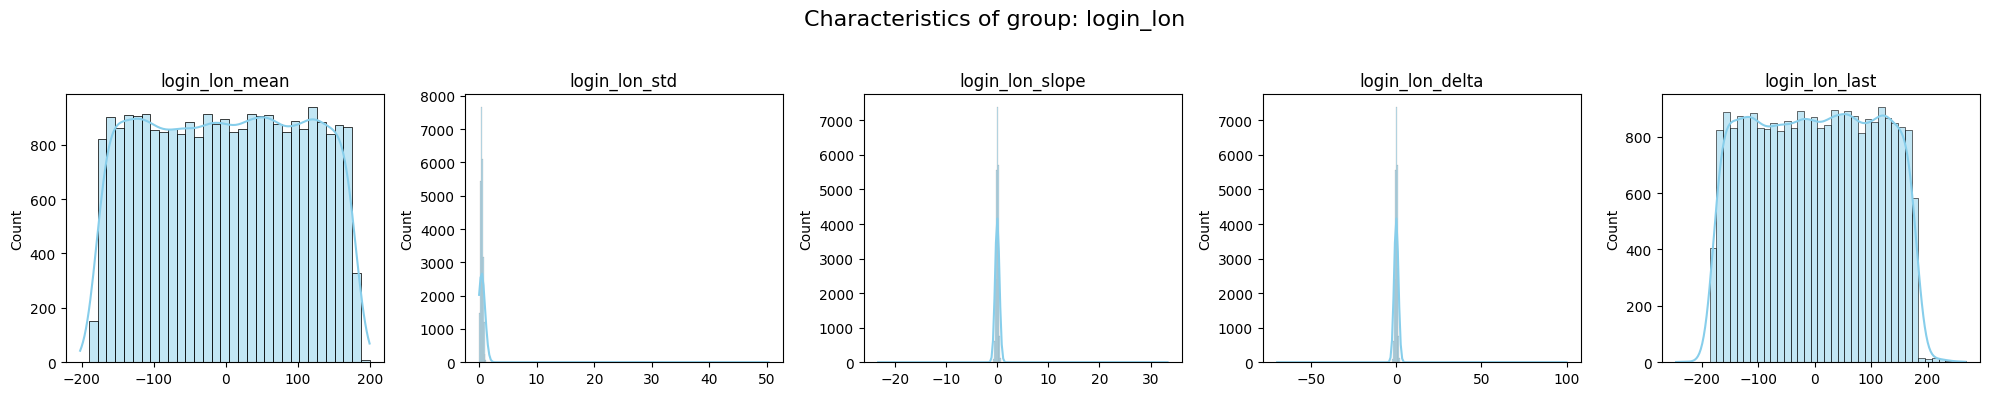

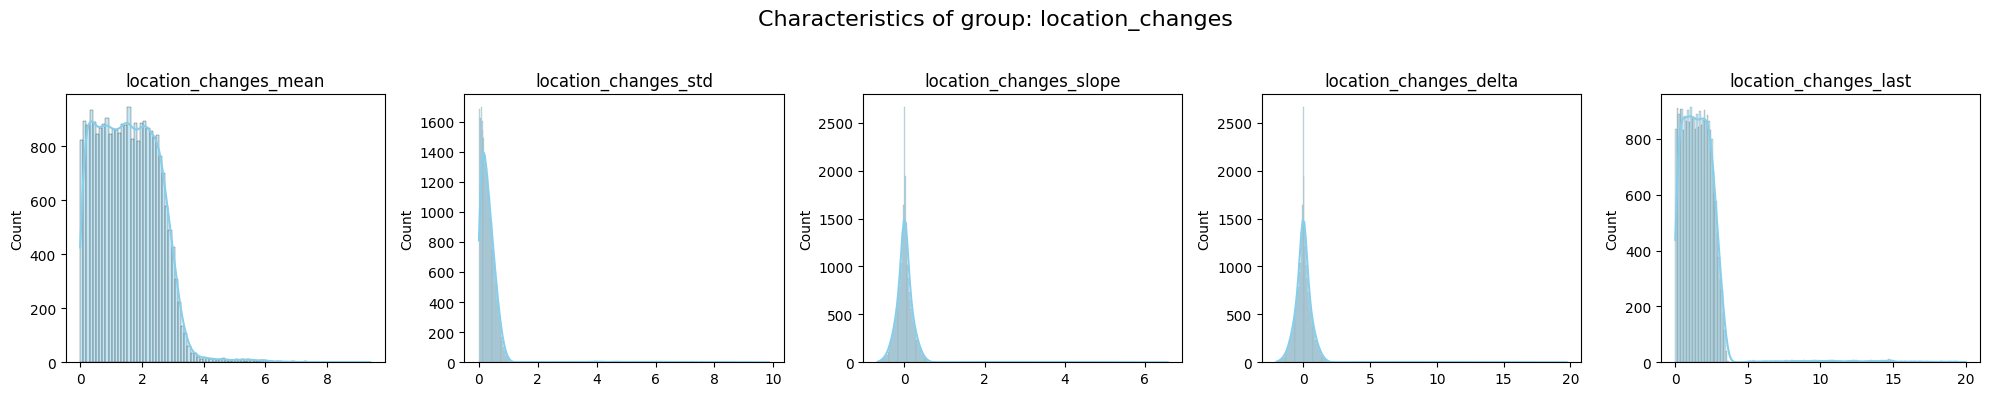

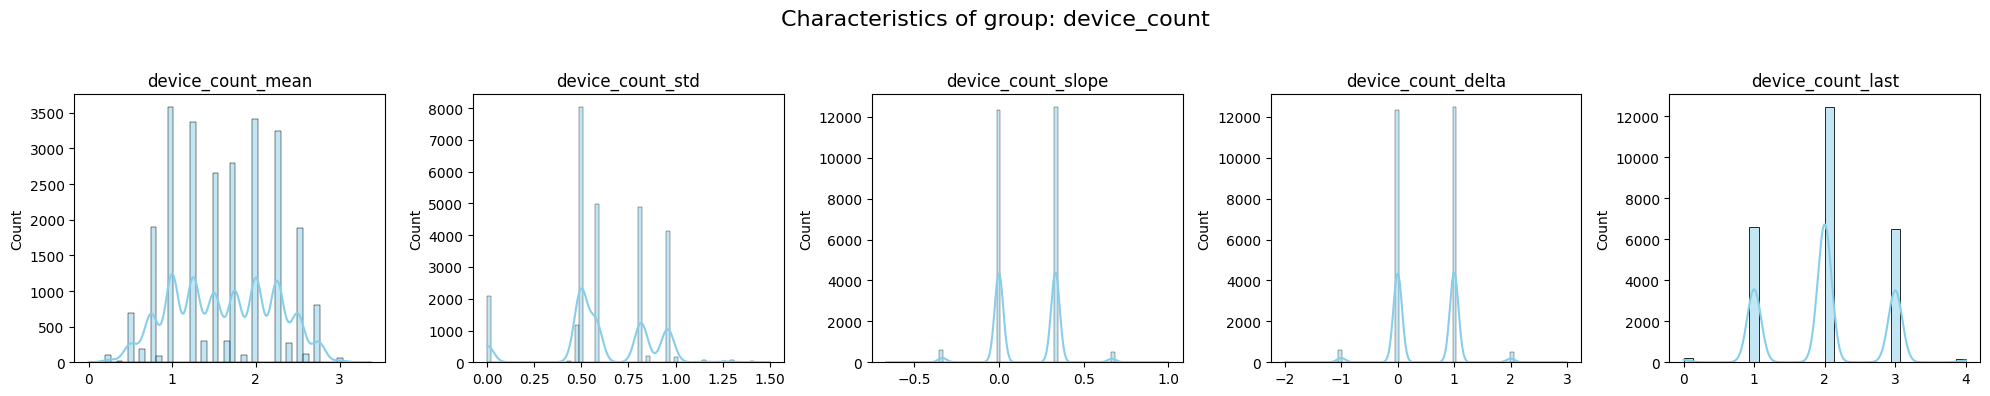

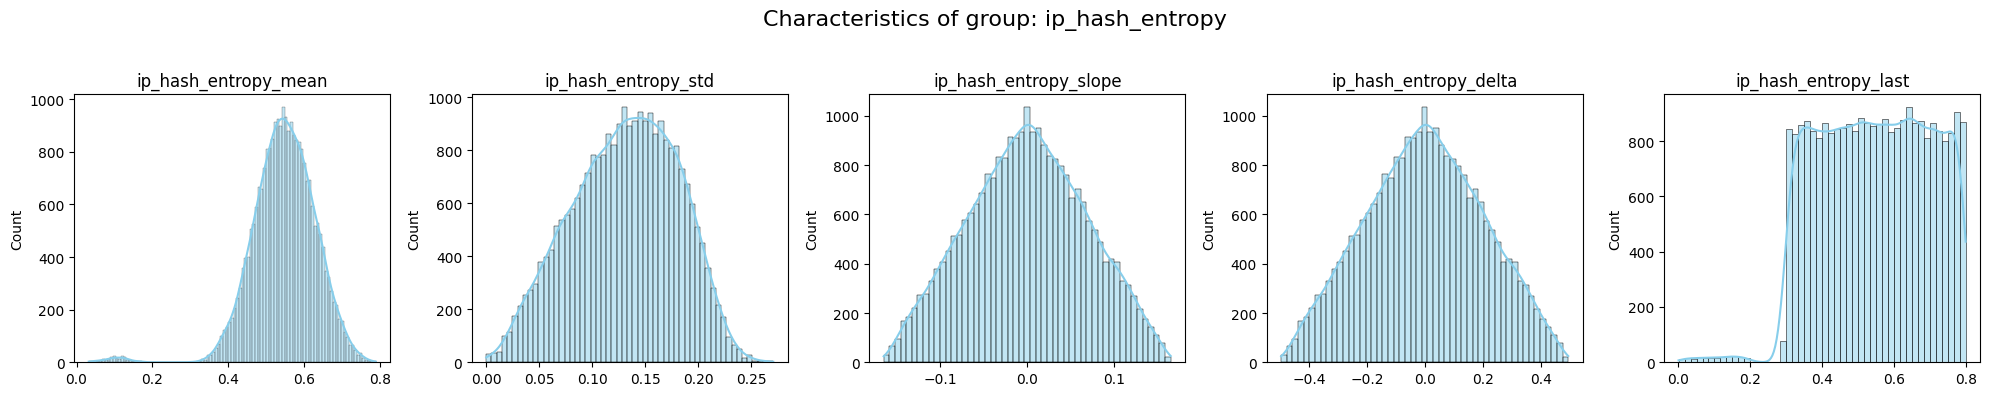

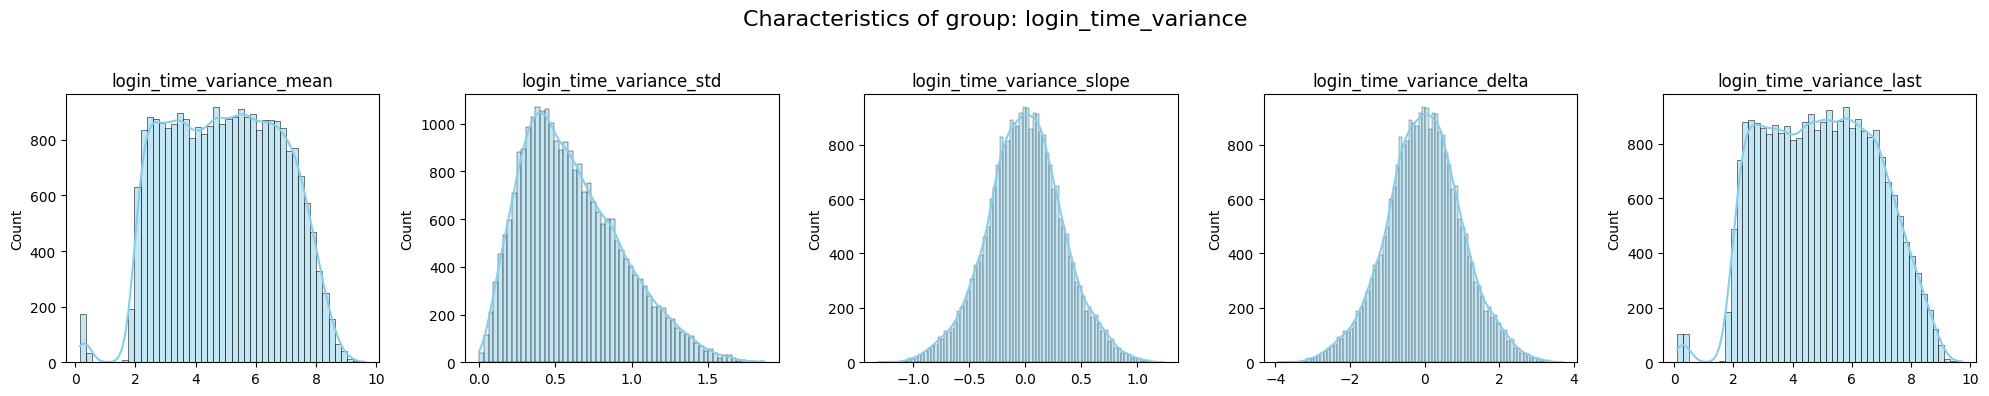

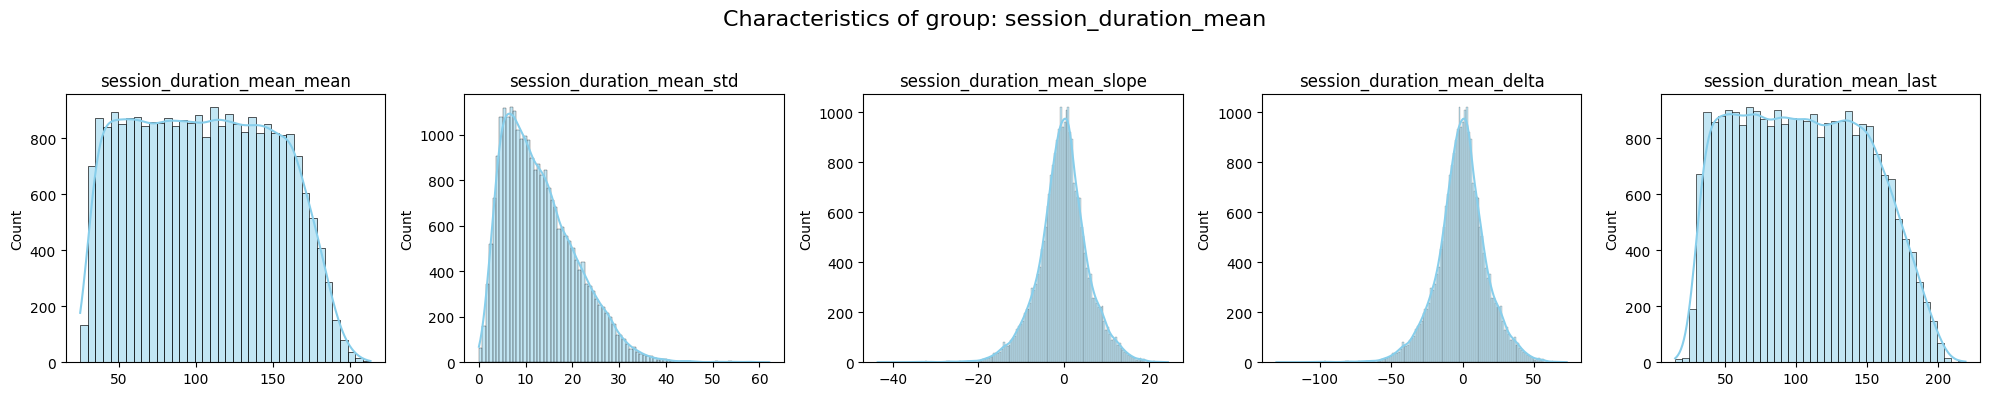

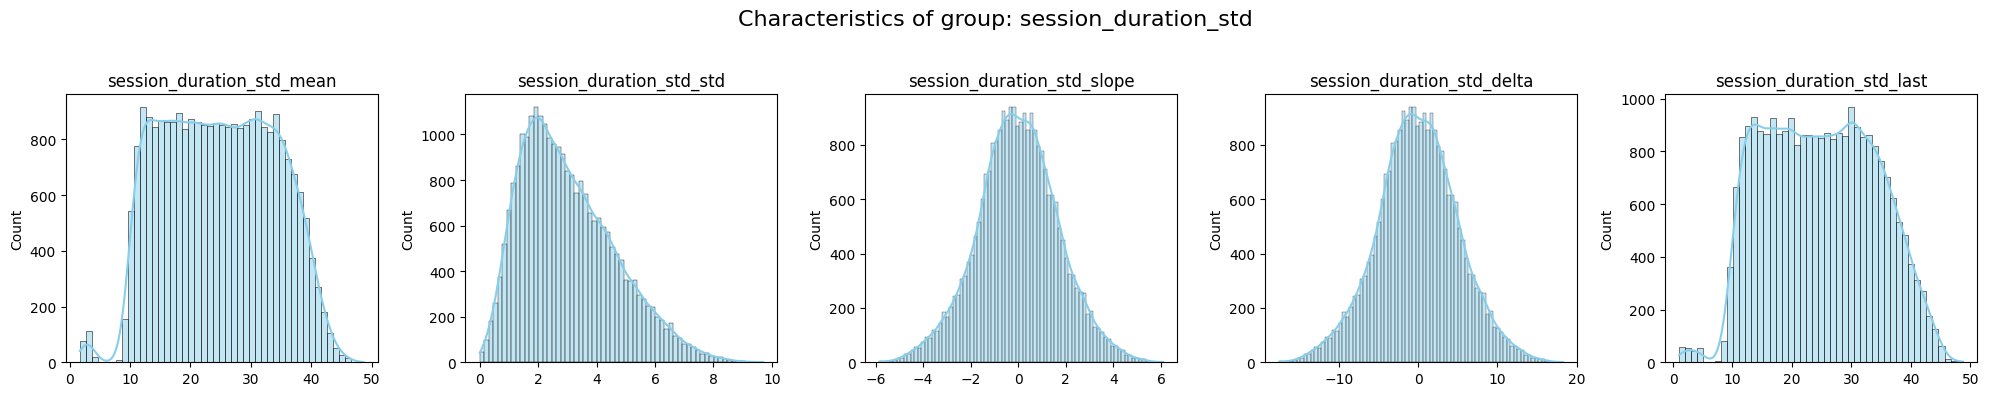

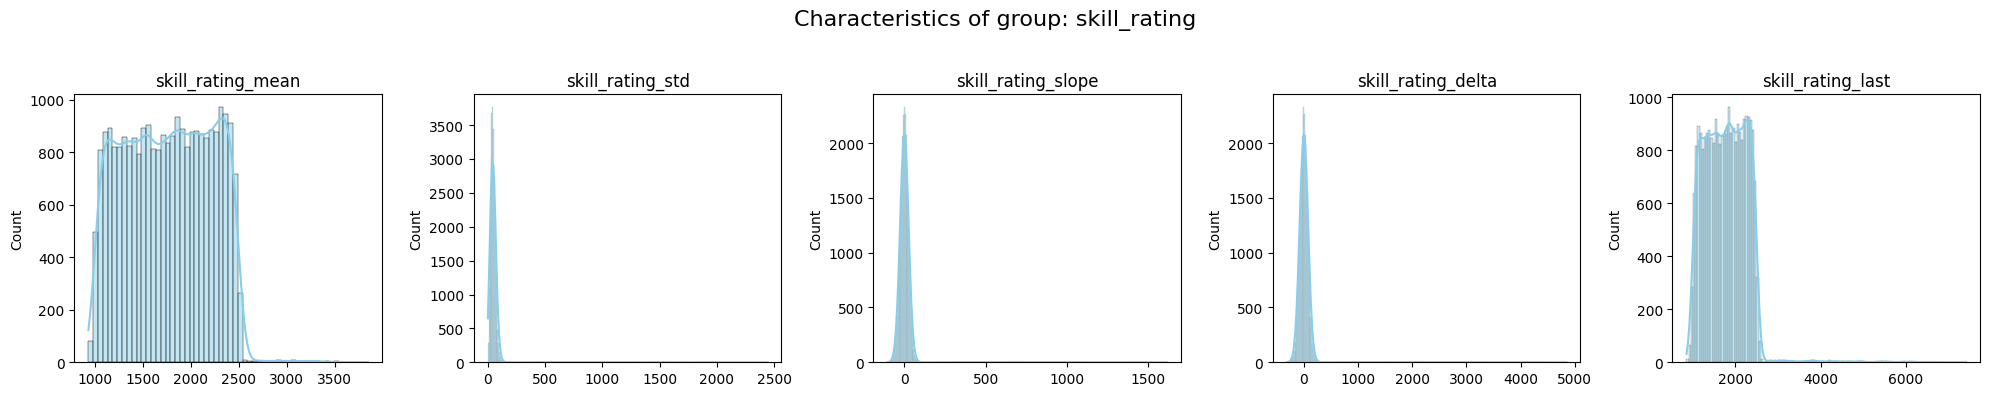

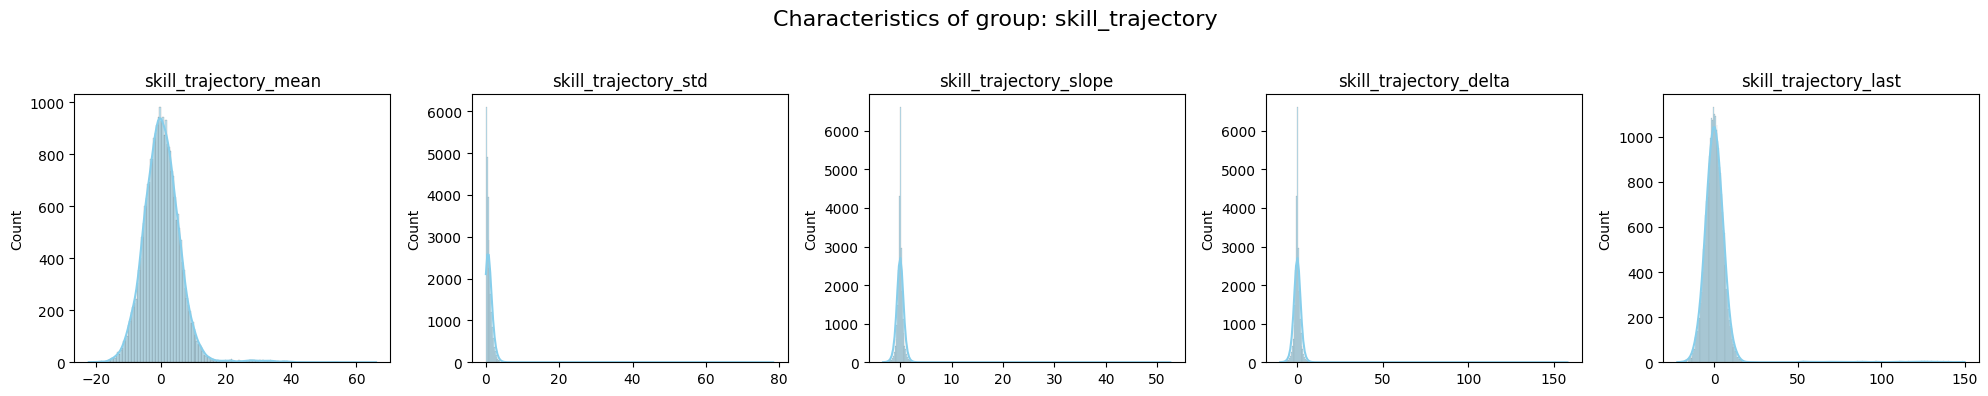

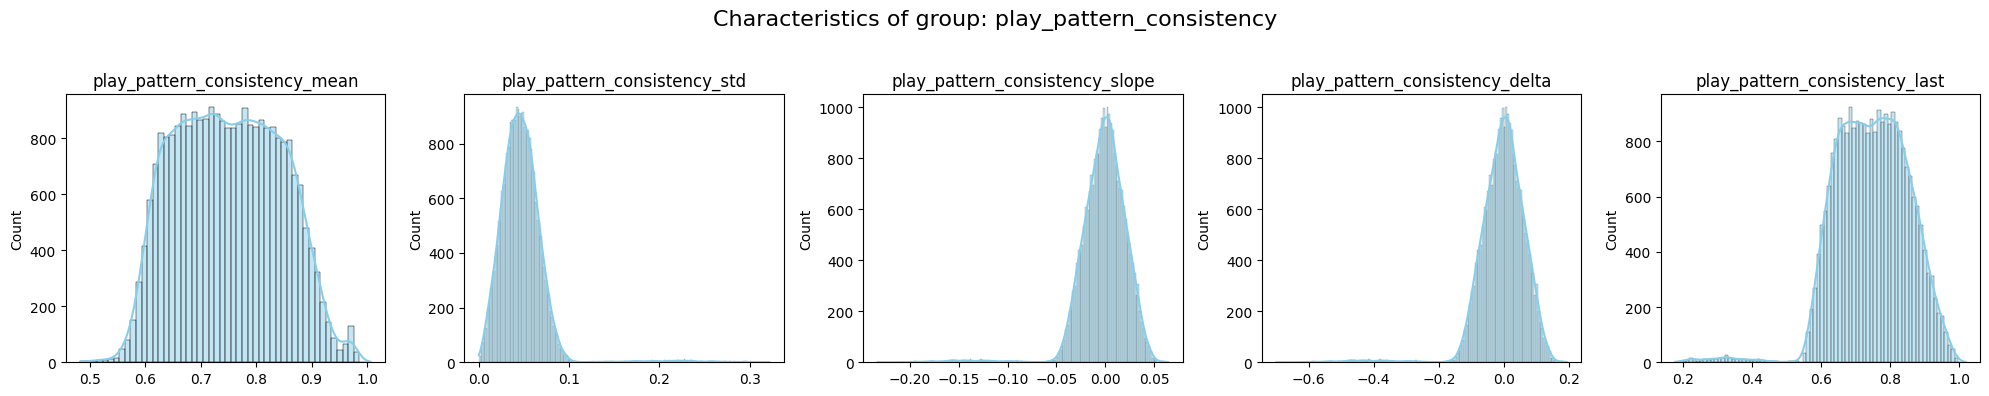

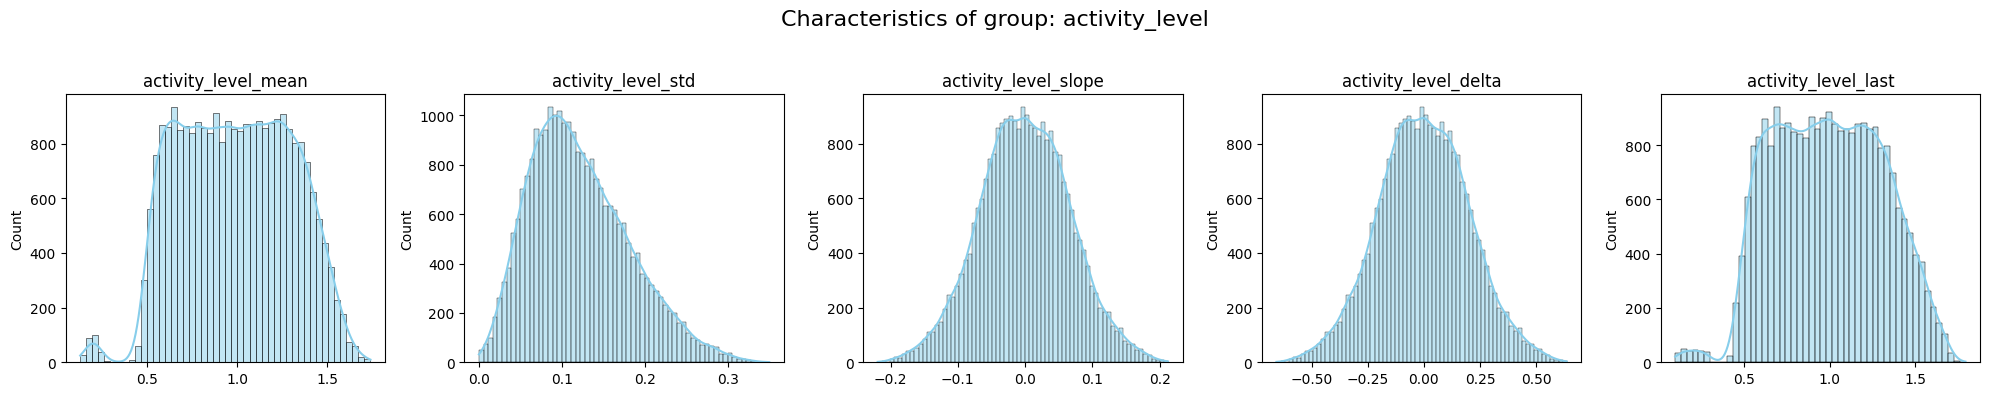

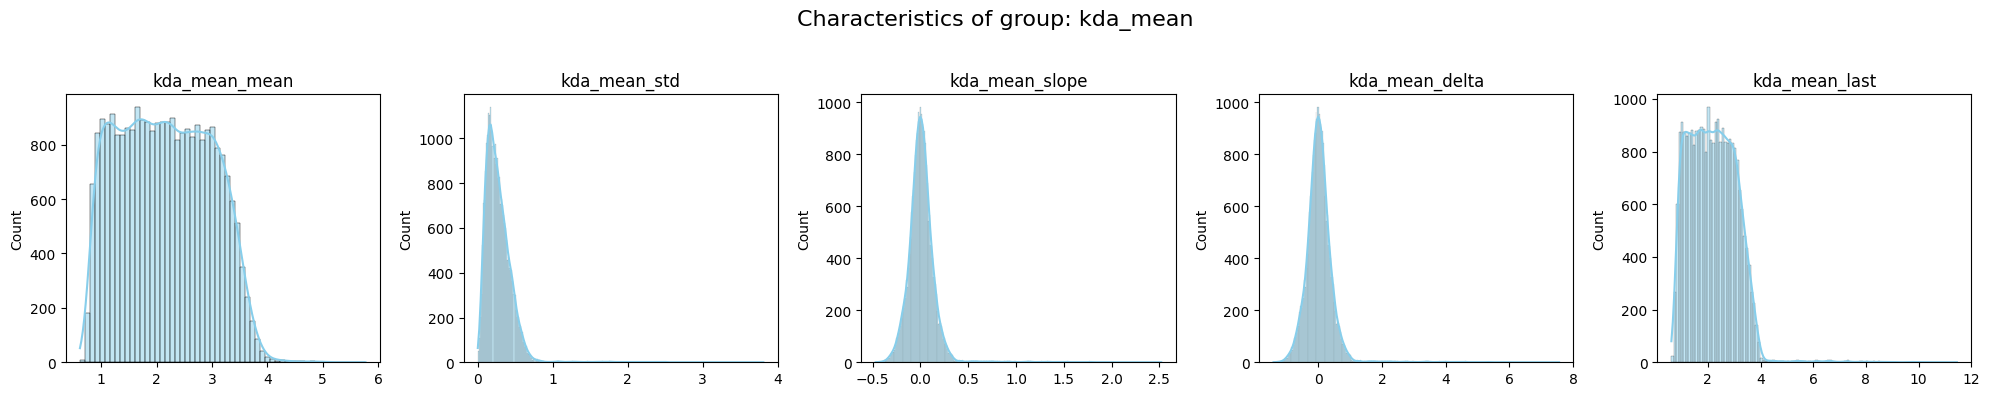

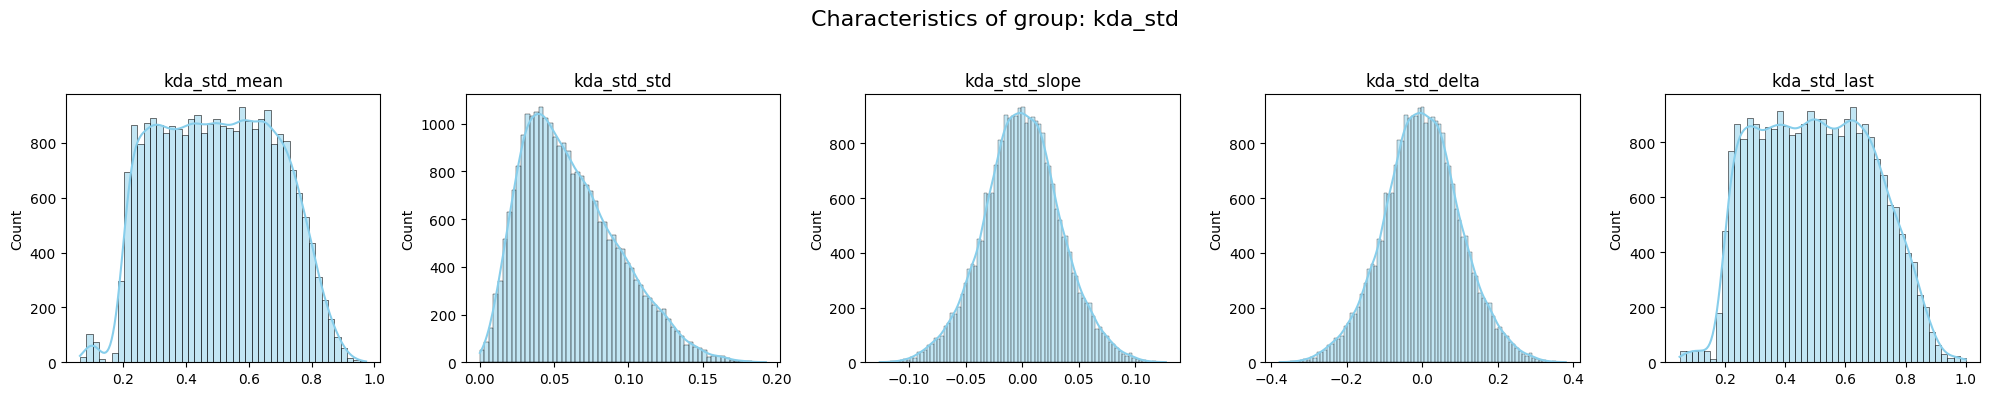

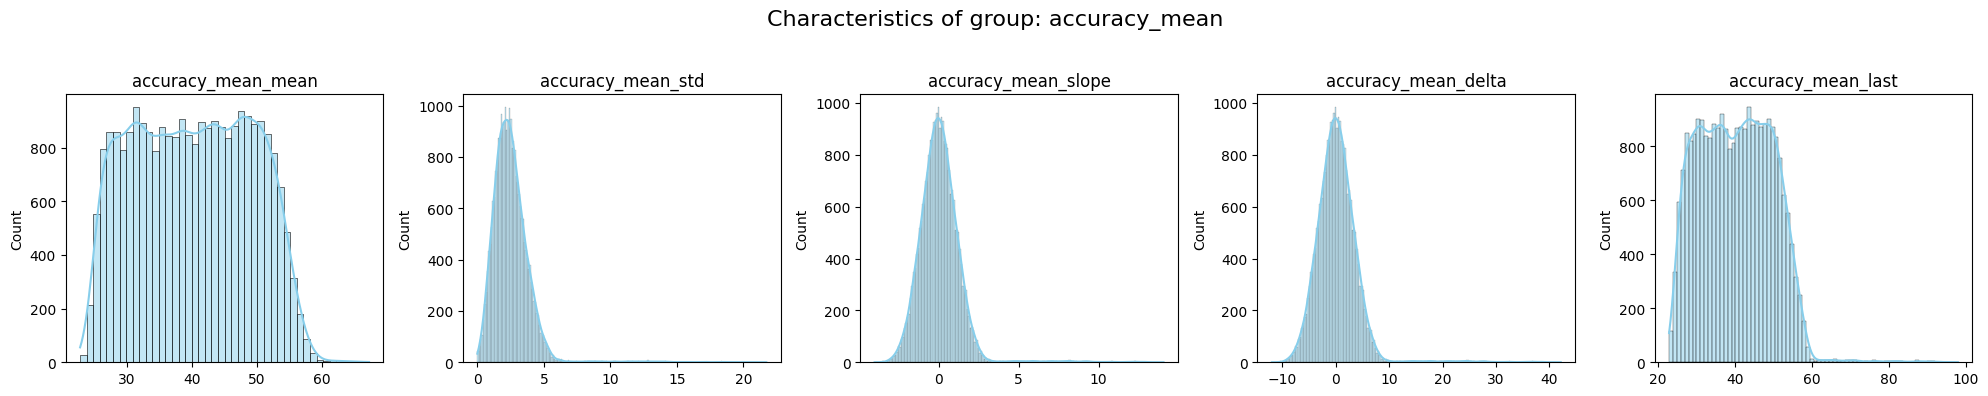

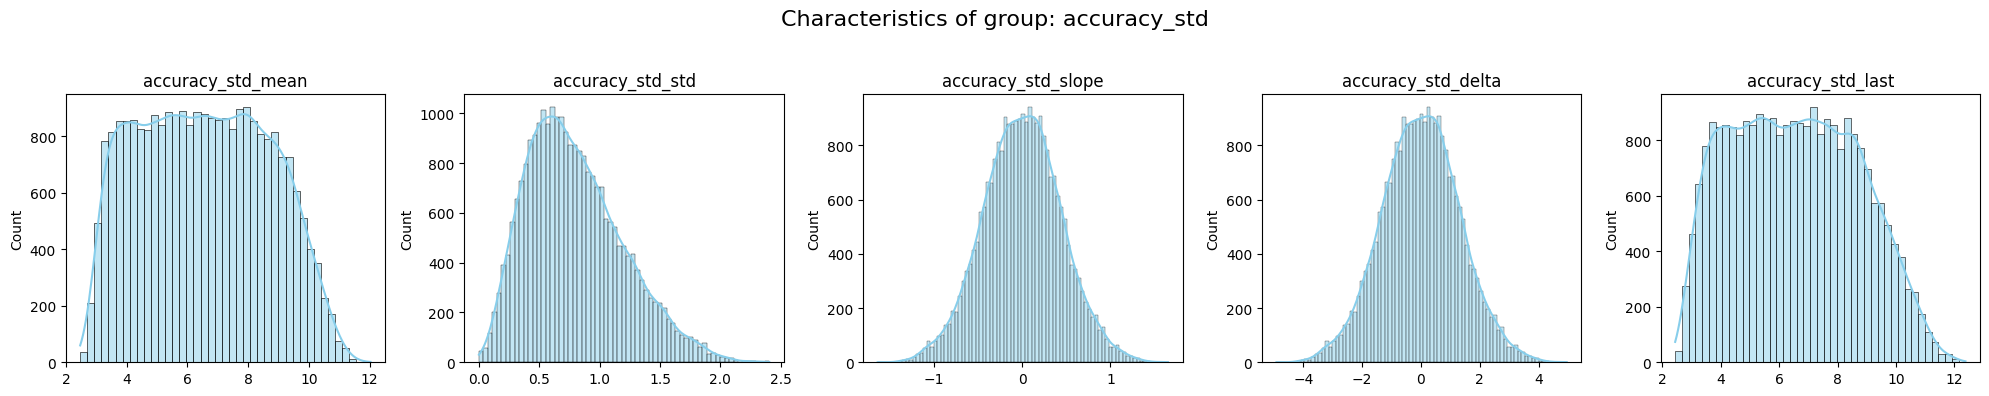

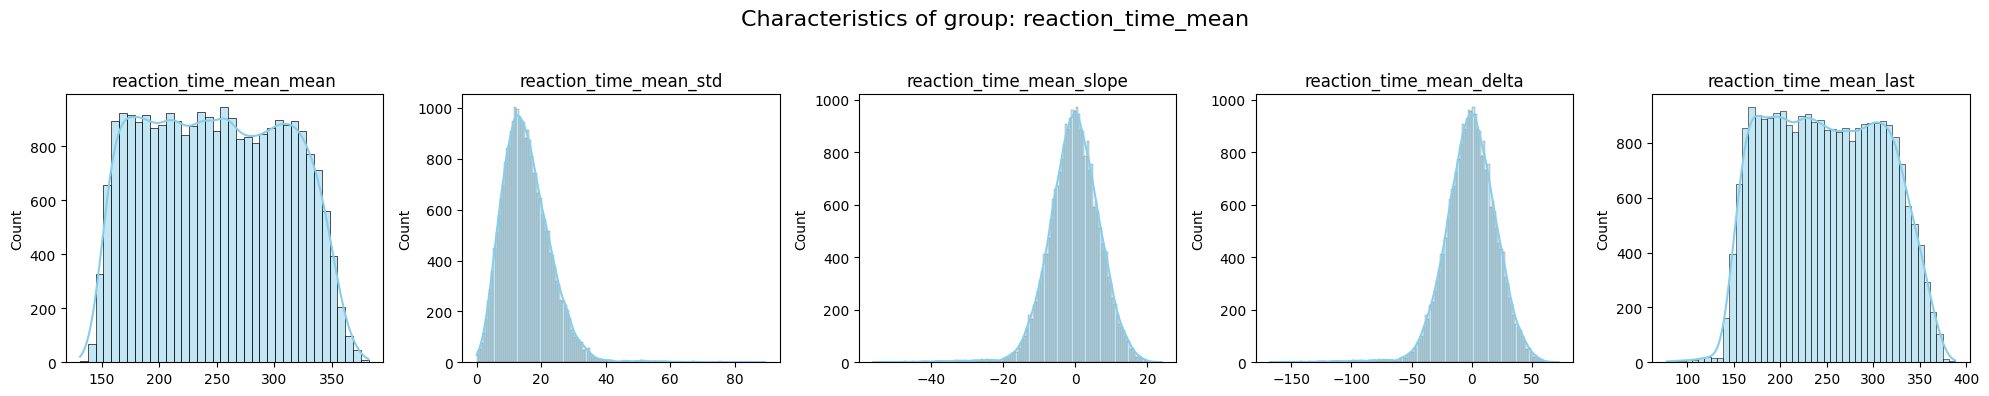

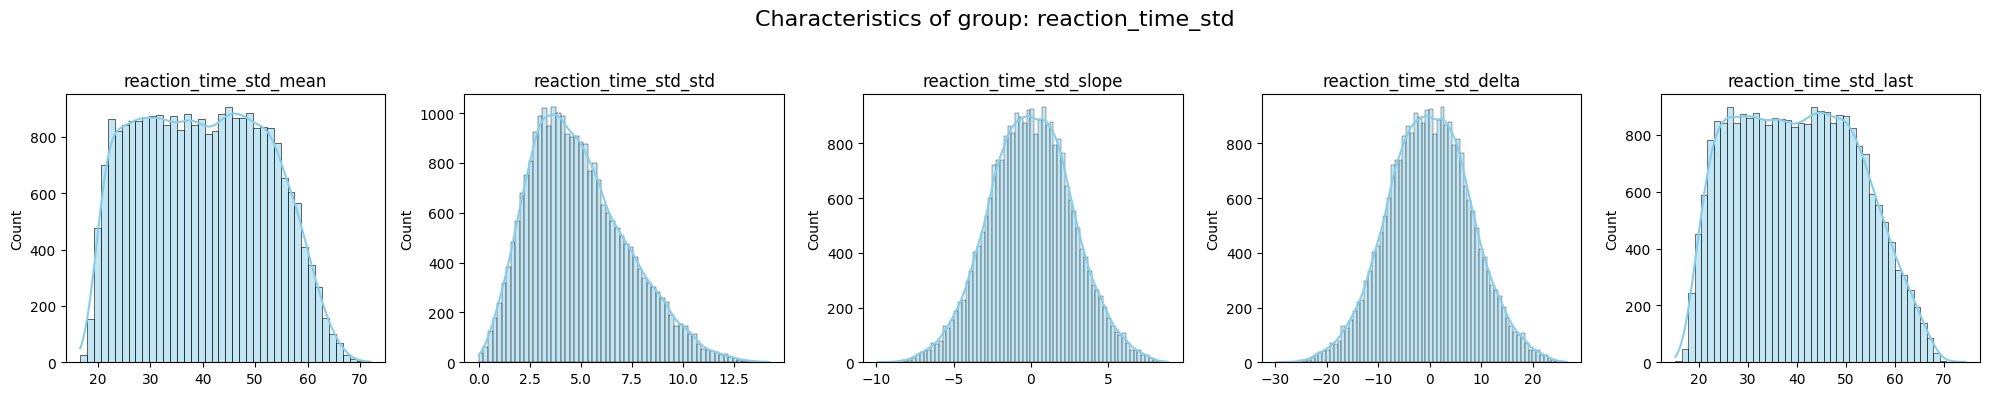

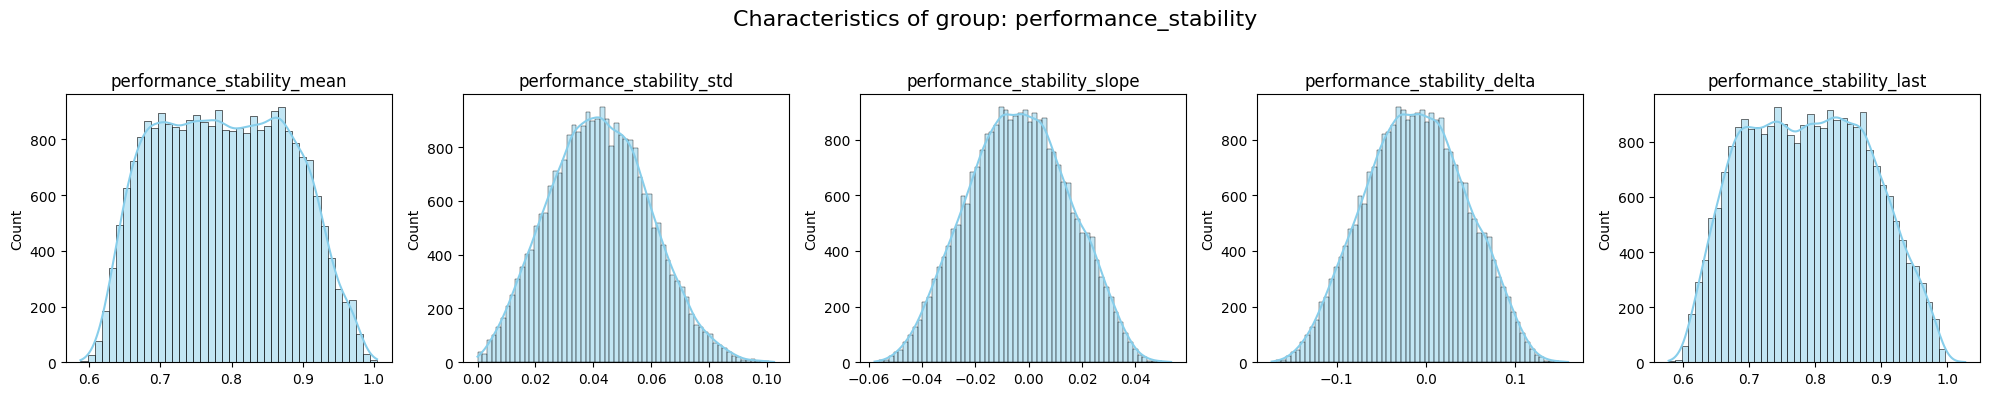

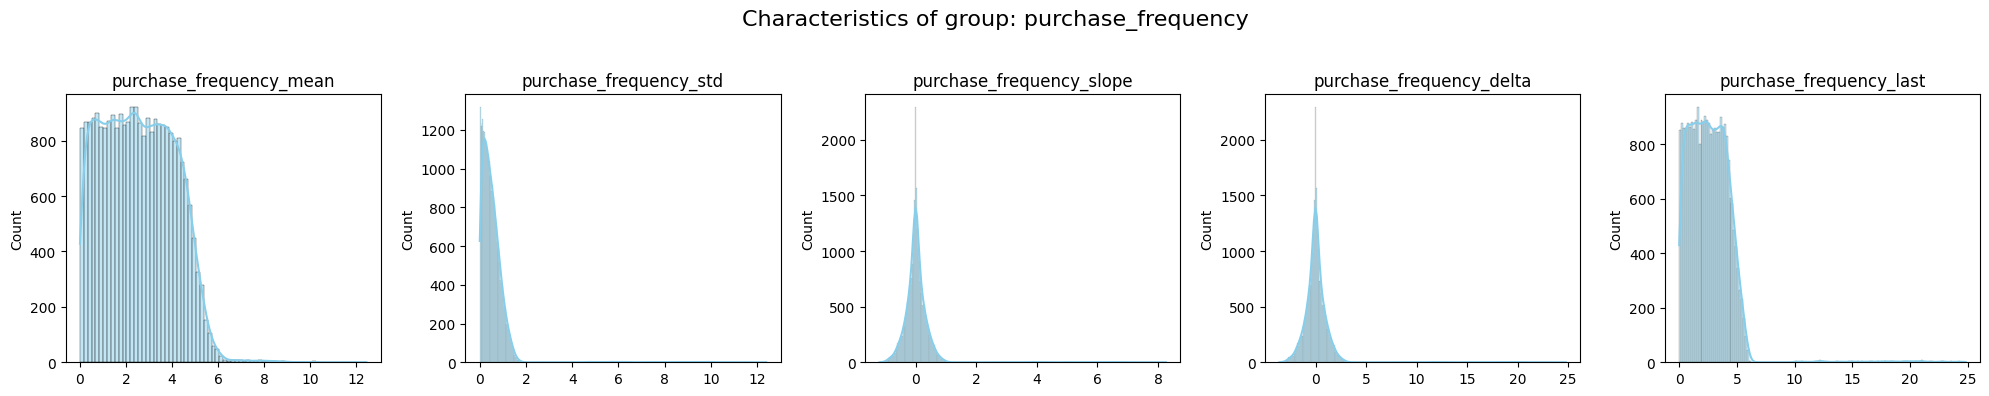

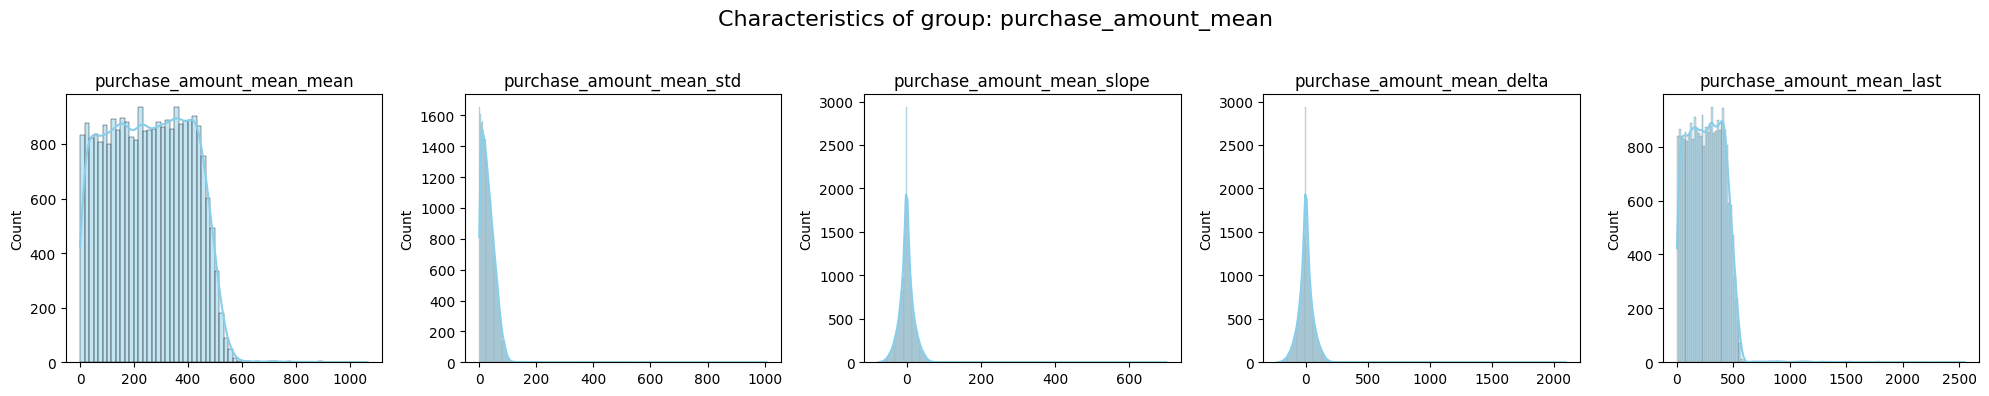

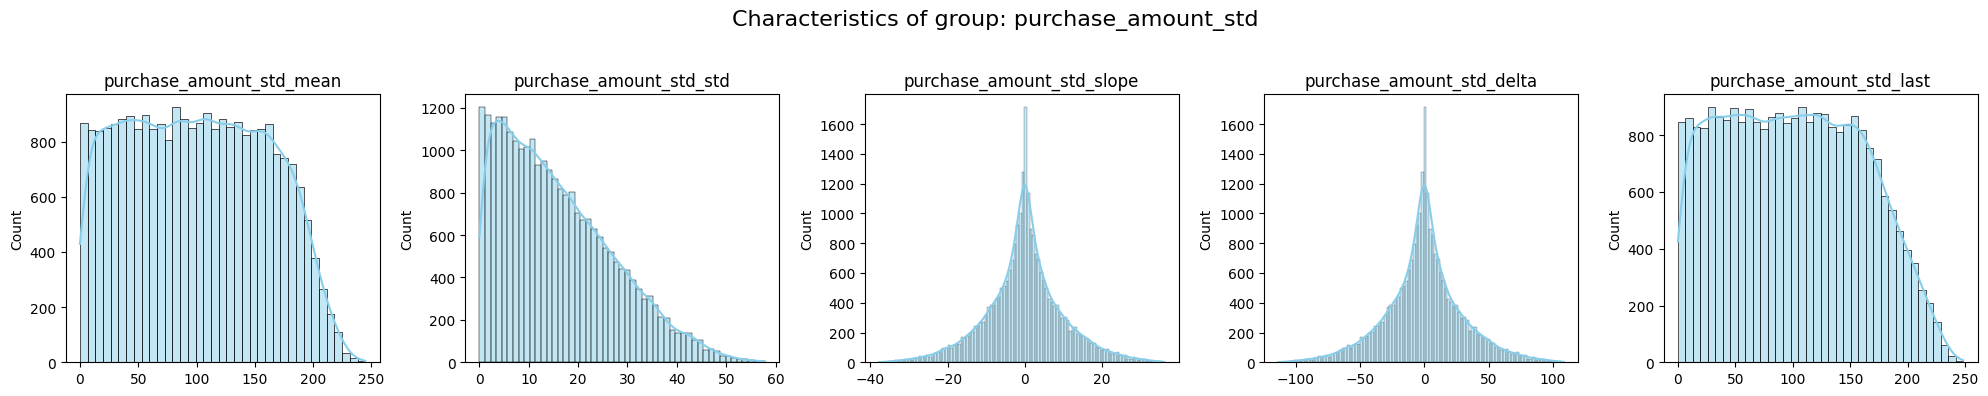

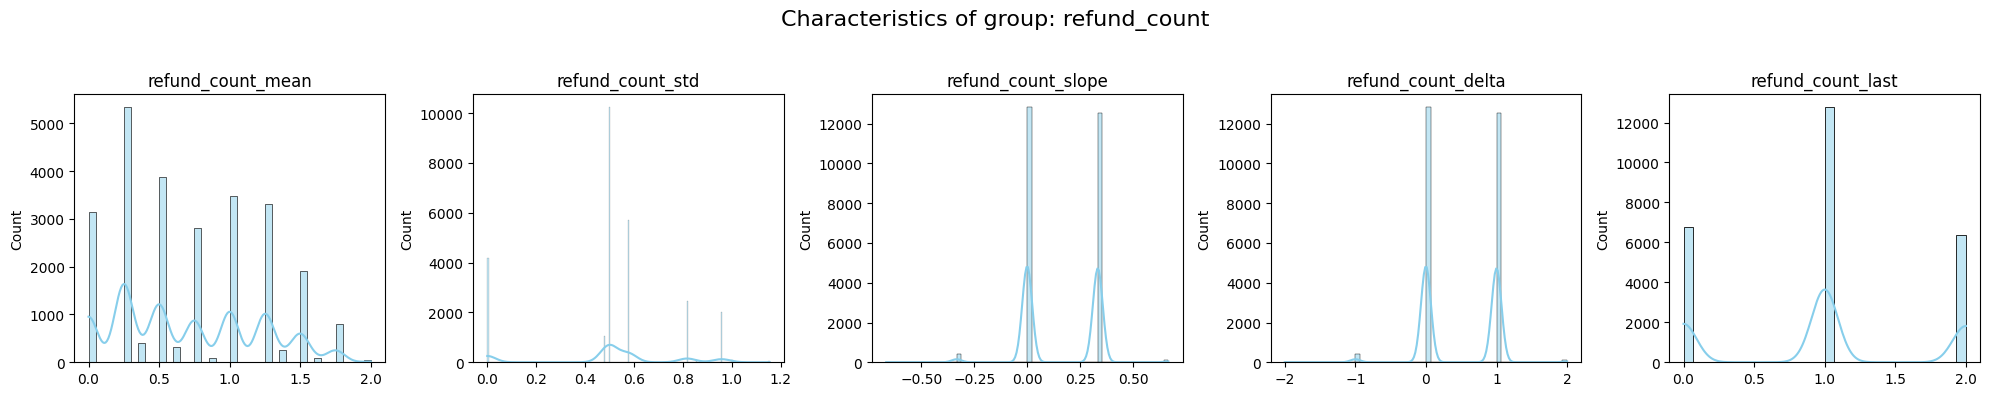

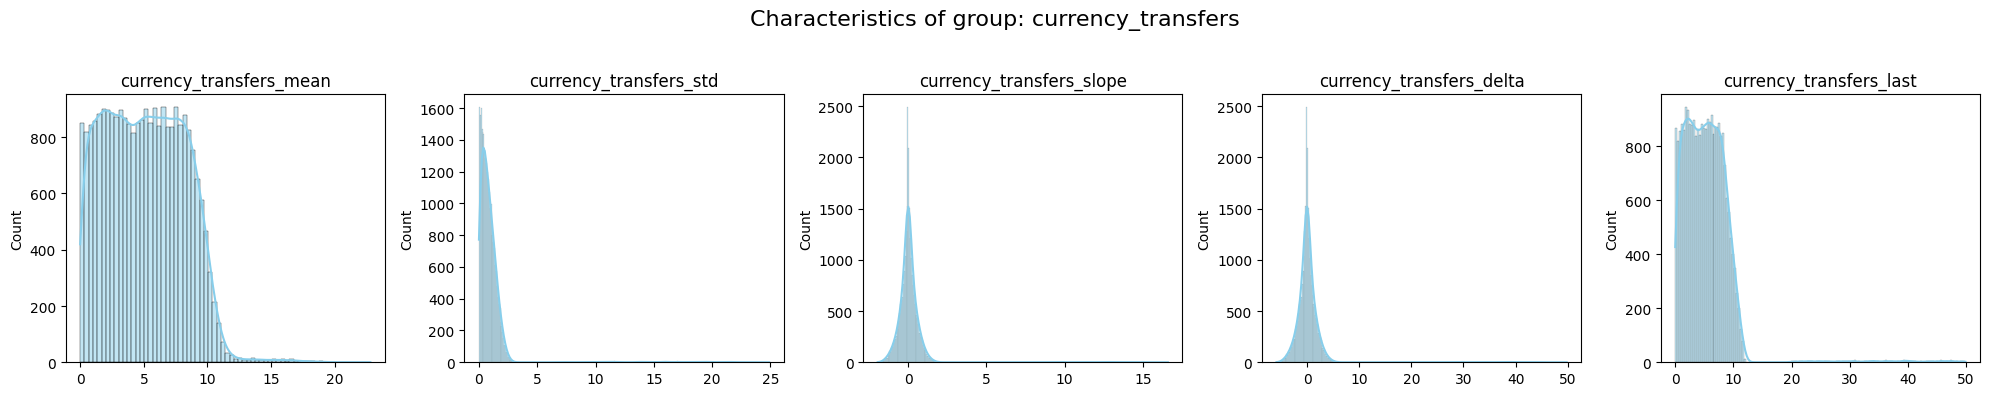

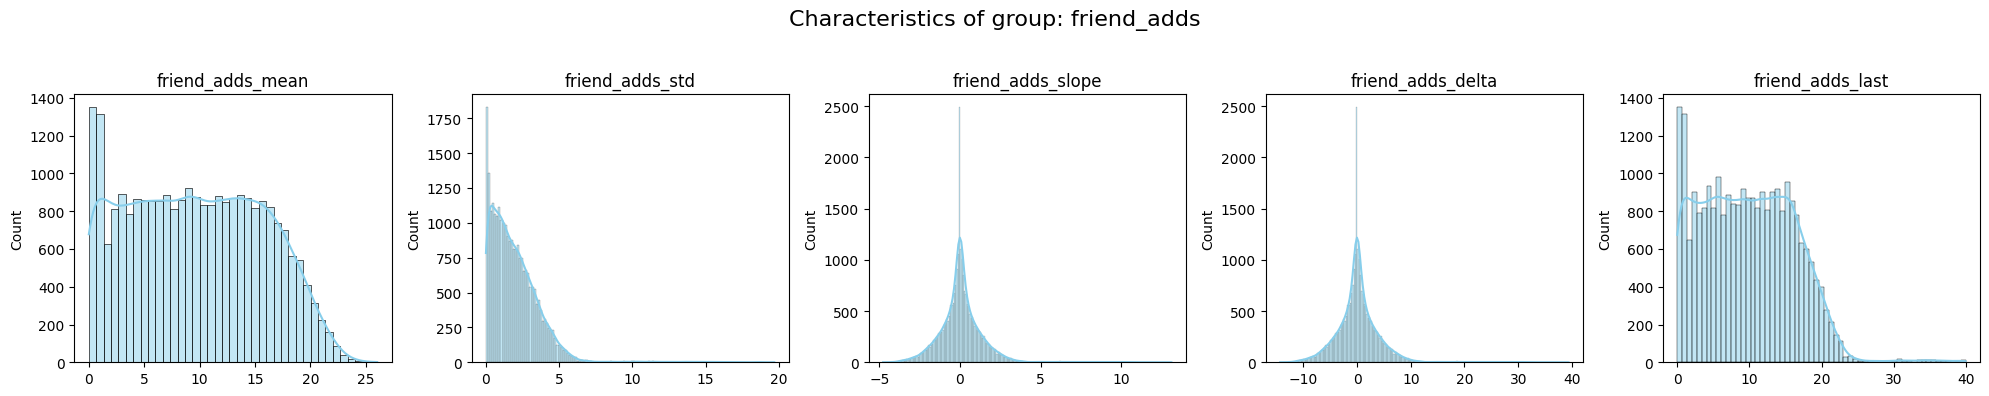

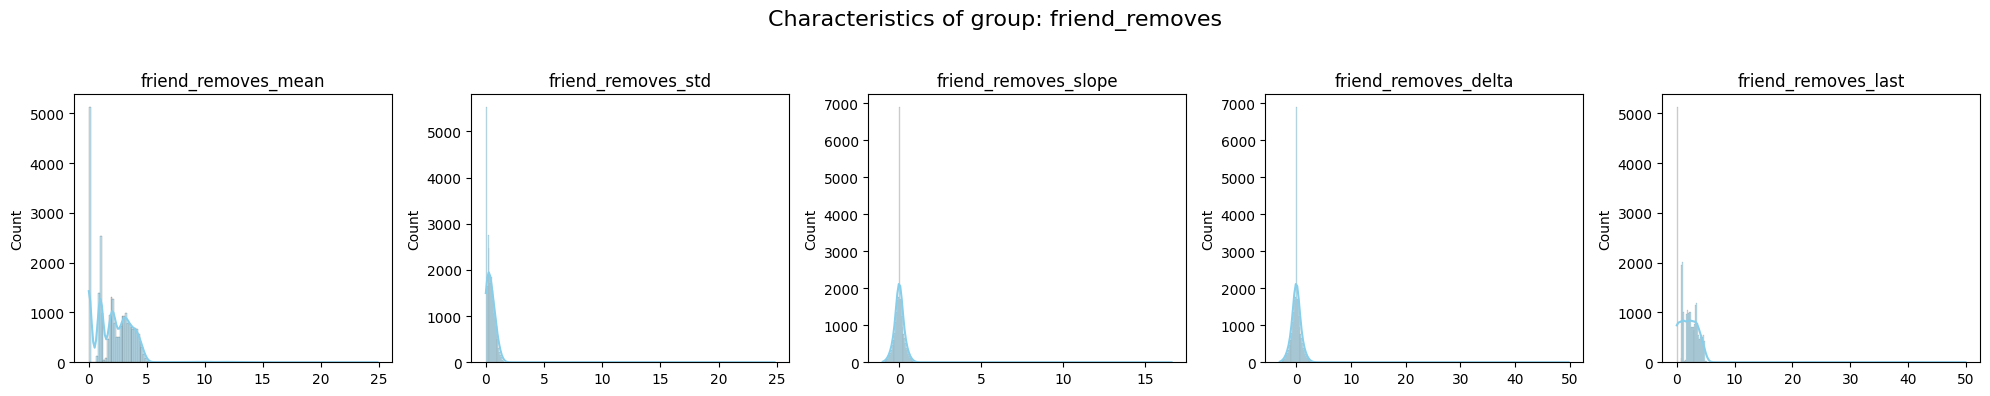

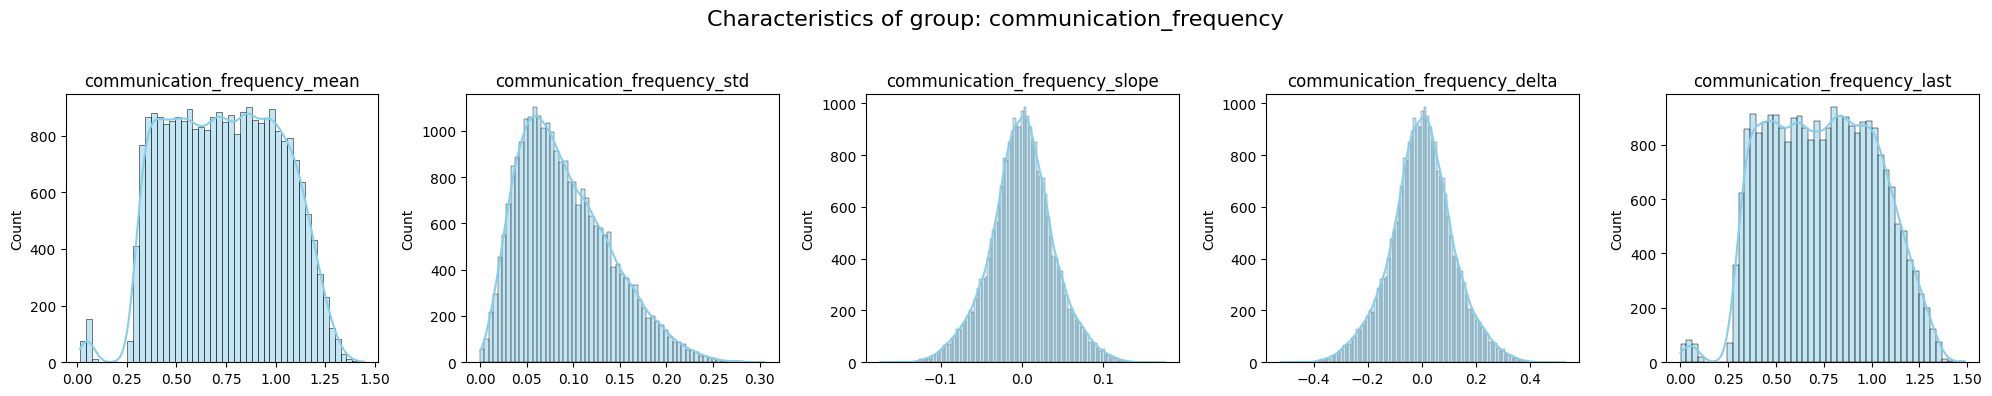

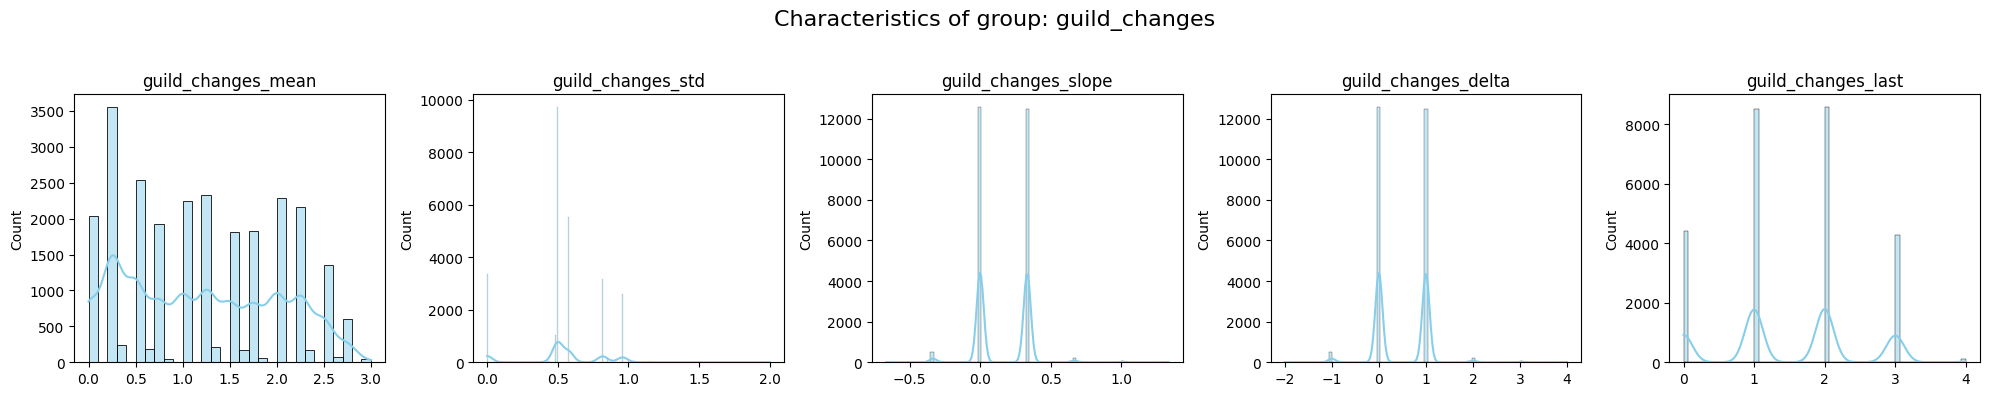

In [101]:
for base, cols in groups.items():
    # Extract the new features for this group
    features = [f"{base}_mean", f"{base}_std", f"{base}_slope", f"{base}_delta", f"{base}_last"]
    data = X[features]
    
    # Create subplots
    fig, axes = plt.subplots(1, len(features), figsize=(20, 4))
    fig.suptitle(f"Characteristics of group: {base}", fontsize=16)
    
    for ax, feature in zip(axes, features):
        sns.histplot(data[feature], kde=True, ax=ax, color='skyblue')
        ax.set_title(feature)
        ax.set_xlabel("")
        ax.set_ylabel("Count")
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    
    # Save figure before showing
    plt.savefig(f"eda_{base}.png", dpi=300)
    
    plt.show()
    plt.close(fig) 

## Preprocessing

In [71]:
# Scale a numeric columns
numeric_cols = X.select_dtypes(include='number').columns

scaler = RobustScaler()
X_scaled = scaler.fit_transform(X[numeric_cols])
X_scaled

array([[-0.42739102,  0.06753166,  0.        , ...,  0.        ,
         0.        , -1.        ],
       [ 0.730789  , -1.01327771,  0.        , ...,  1.        ,
         1.        , -1.        ],
       [-0.01994766, -0.20194653,  0.        , ...,  0.        ,
         0.        , -2.        ],
       ...,
       [-0.04166873, -1.00249769,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.50180724, -0.61005912,  0.        , ...,  0.        ,
         0.        , -1.        ],
       [-0.60596311,  0.        ,  0.        , ...,  1.        ,
         1.        , -1.        ]], shape=(25889, 151))

In [72]:
# Apply PCA to reduce dimensionality
pca = PCA(n_components=0.95, random_state=42)  # preserve 95% variance
X_pca = pca.fit_transform(X_scaled)

print("Original shape:", X_scaled.shape)
print("PCA shape:", X_pca.shape)

Original shape: (25889, 151)
PCA shape: (25889, 20)


## Modeling

In [77]:
CONTAMINATION = 0.10  # Expected anomaly proportion
NU = 0.10             # OneClassSVM outlier fraction

# Isolation Forest
iso = IsolationForest(contamination=CONTAMINATION, random_state=42)
iso_pred = iso.fit(X_pca)

# One-Class SVM
oc_svm = OneClassSVM(kernel='rbf', gamma='scale', nu=NU)
svm_pred = oc_svm.fit(X_pca)

### Soft Score Averaging Ensemble

In [ ]:
scores = pd.DataFrame(
    {
        "iso": -iso.decision_function(X_pca),
        "oc_svm": -oc_svm.decision_function(X_pca)
    }, index= X.index,
)

scores.describe()

,iso,oc_svm
count,25889.000000,25889.000000
mean,-0.030211,-15.419530
std,0.039619,262.888006
min,-0.084522,-132.884228
25%,-0.052302,-94.392528
50%,-0.037790,-62.472990
75%,-0.020101,-34.294203
max,0.244601,1433.736045


In [90]:
score_scaler = MinMaxScaler()
scores_scaled = score_scaler.fit_transform(scores)
scores_scaled

array([[0.15579259, 0.02880599],
       [0.08280611, 0.01452217],
       [0.08853697, 0.01445691],
       ...,
       [0.14657141, 0.0786427 ],
       [0.14158375, 0.01967309],
       [0.09656298, 0.05103666]], shape=(25889, 2))

## Prediction

In [91]:
ensemble_scores = scores_scaled.mean(axis=1)

print("Ensembled score summary (before thresholding):")
pd.Series(ensemble_scores).describe()

Ensembled score summary (before thresholding):


count    25889.000000
mean         0.119999
std          0.138913
min          0.000000
25%          0.064956
50%          0.093665
75%          0.127491
max          0.999849
dtype: float64

In [97]:
threshold = np.quantile(ensemble_scores, 1 - CONTAMINATION)

print(f"Using contamination={CONTAMINATION:.3f}")
print(f"Anomaly threshold on ensemble score: {threshold:.6f}")

task5_pred = (ensemble_scores >= threshold).astype(int)
task5_pred

X['is_anomaly'] = task5_pred
X['is_anomaly'].value_counts()

Using contamination=0.100
Anomaly threshold on ensemble score: 0.165047


is_anomaly
0    23300
1     2589
Name: count, dtype: int64

## Visualization

In [105]:
# PCA 2 components
pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(X_scaled)

# DataFrame สำหรับ plot
pca_df = pd.DataFrame({
    'PC1': pca_result[:, 0],
    'PC2': pca_result[:, 1],
    'is_anomaly': X['is_anomaly'].values
})

In [108]:
# สร้าง DataFrame ของ loadings
loadings = pd.DataFrame(
    pca.components_.T,
    columns=['PC1', 'PC2'],
    index=X.drop(columns=['is_anomaly']).columns
)

# แสดง top features สำหรับแต่ละ PC ตาม absolute value
for pc in ['PC1', 'PC2']:
    print(f"\nTop features for {pc}:")
    print(loadings[pc].abs().sort_values(ascending=False).head(10))


Top features for PC1:
login_lon_std               0.648097
login_lat_std               0.470745
login_lon_slope             0.324389
login_lon_delta             0.324389
login_lat_delta             0.225202
login_lat_slope             0.225202
location_changes_slope      0.088433
location_changes_delta      0.088433
currency_transfers_slope    0.084008
currency_transfers_delta    0.084008
Name: PC1, dtype: float64

Top features for PC2:
skill_trajectory_delta    0.507105
skill_trajectory_slope    0.507105
skill_trajectory_std      0.388008
friend_removes_slope      0.287927
friend_removes_delta      0.287927
skill_rating_std          0.227162
friend_removes_std        0.212056
skill_rating_delta        0.138611
skill_rating_slope        0.138611
skill_trajectory_last     0.100366
Name: PC2, dtype: float64


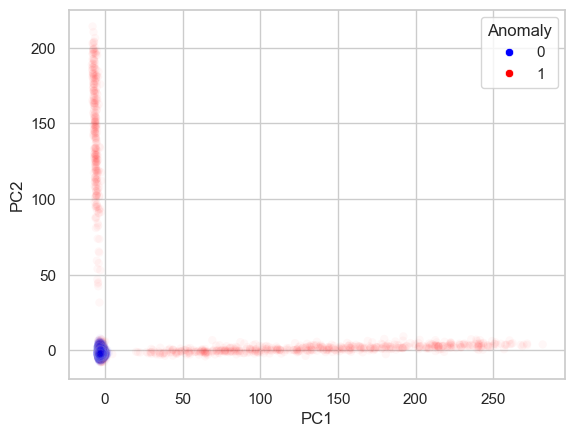

In [ ]:
sns.scatterplot(
    x='PC1',
    y='PC2',
    hue='is_anomaly',
    data=pca_df,
    palette={0: 'blue', 1: 'red'},
    alpha=0.03,
    legend='full'
)

handles, labels = plt.gca().get_legend_handles_labels()
for handle in handles:
    handle.set_alpha(1)
plt.legend(handles=handles, labels=labels, title='Anomaly')